# Import packages

In [1]:
%reset
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import datetime

# CoVariants data

## Acquire data from CoVariants Github

In [2]:
!wget https://raw.githubusercontent.com/hodcroftlab/covariants/master/web/data/perCountryData.json
!mv perCountryData.json ../Data/metadata/CoVariants_data/.

--2022-09-30 21:15:25--  https://raw.githubusercontent.com/hodcroftlab/covariants/master/web/data/perCountryData.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9322654 (8.9M) [text/plain]
Saving to: ‘perCountryData.json’

perCountryData.json 100%[===================>]   8.89M  2.31MB/s    in 4.0s    

2022-09-30 21:15:30 (2.22 MB/s) - ‘perCountryData.json’ saved [9322654/9322654]



## Read data

In [3]:
with open('../Data/metadata/CoVariants_data/perCountryData.json', 'r') as f:
    j = json.load(f)

## Focus on certain data (color setting)

In [4]:
j['regions'][0]['cluster_names']

['20A.EU2',
 '20A/S:126A',
 '20A/S:439K',
 '20A/S:98F',
 '20B/S:1122L',
 '20B/S:626S',
 '20B/S:732A',
 '20C/S:80Y',
 '20E (EU1)',
 '20H (Beta, V2)',
 '20I (Alpha, V1)',
 '20J (Gamma, V3)',
 '21A (Delta)',
 '21B (Kappa)',
 '21C (Epsilon)',
 '21D (Eta)',
 '21F (Iota)',
 '21G (Lambda)',
 '21H (Mu)',
 '21I (Delta)',
 '21J (Delta)',
 '21K (Omicron)',
 '21L (Omicron)',
 '22A (Omicron)',
 '22B (Omicron)',
 '22C (Omicron)',
 '22D (Omicron)',
 'S:677H.Robin1',
 'S:677P.Pelican']

In [5]:
countries_focus = ['United Kingdom', 'Israel', 'South Africa', 'Brazil', 'Peru']
# 9: beta, 10: alpha, 11: gamma, 12,19,20: delta, 14: epsilon, 17: lambda, 18: mu, 21,22,23,24,25,26: omicron
variants_focus = j['regions'][0]['cluster_names'][9:13] + j['regions'][0]['cluster_names'][14:15] + j['regions'][0]['cluster_names'][17:27]
mycolors = {
    '20I (Alpha, V1)': '#1f77b4',
    '20H (Beta, V2)': '#ff7f0e',
    '20J (Gamma, V3)': '#2ca02c',
    '21A (Delta)': '#d62748',
    '21I (Delta)': '#d66b7f',
    '21J (Delta)': '#dba4af',
    '21C (Epsilon)': '#9467bd',
    '21G (Lambda)': '#8c564b',
    '21H (Mu)': '#e377c2',
    '21K (Omicron)':'#ffffff',
    '21L (Omicron)':'#ffffdf',
    '22A (Omicron)':'#ffffbf',
    '22B (Omicron)':'#ffff9f',
    '22C (Omicron)':'#ffff7f',
    '22D (Omicron)':'#ffff5f',
    'others':'#adadad'
}

## Data processing

In [6]:
dfs = {}
# regions (world: 0, United States: 1, Switzerland: 2)
# distributions (111 countries)
for i in j['regions'][0]['distributions']:
    
    if i['country'] in countries_focus:
        print(i['country'])
        print(len(i['distribution']))
        week_list = []
        total_seqs_list = []
        cluster_counts_list = []
        unique_e = []

        for k in i['distribution']:
            week_list.append(k['week'])
            total_seqs_list.append(k['total_sequences'])
            week_cluster_counts = []

            for variant in variants_focus:
                try:
                    #print(f"{variant}: {k['cluster_counts'][variant]}")
                    week_cluster_counts.append(k['cluster_counts'][variant])
                except Exception as e:
                    if not str(e) in unique_e:
                        print(e)
                        unique_e.append(str(e))
                    week_cluster_counts.append(int(0))
            
            others = int(k['total_sequences']) - sum(np.array(week_cluster_counts))
            week_cluster_counts.append(others)
            cluster_counts_list.append(week_cluster_counts)
        
        df = pd.DataFrame(cluster_counts_list)
        df.columns = variants_focus + ['others']
        df.index = pd.to_datetime(week_list) + datetime.timedelta(days=7)  # day calibration

        dfs[i['country']] = df.copy()
        print('---------------------')



United Kingdom
63
---------------------
Brazil
63
'21C (Epsilon)'
'22D (Omicron)'
---------------------
Israel
58
---------------------
South Africa
62
'20J (Gamma, V3)'
'21C (Epsilon)'
'21G (Lambda)'
'21H (Mu)'
---------------------
Peru
62
'20H (Beta, V2)'
---------------------


## filter bias variant frequency data in Israel

In [7]:
dfs['Israel'] = dfs['Israel'].drop(['2020-10-19'])

## Save data

In [8]:
for country in countries_focus:
    df = dfs[country]
    #df.to_csv(f"./CoVariants_{country}_calibrateDAY.csv")

## TESTING codes (you can remove)

In [9]:
# testing codes
for i in j['regions'][0]['distributions']:
    if i['country'] in countries_focus:
        print(i['country'])
        print(len(i['distribution']))
        for k in i['distribution']:
            print(k['week'])
            print(k['total_sequences'])
            for variant in variants_focus:
                print(f"{variant}: {k['cluster_counts'][variant]}")
        print('---------------------')

    break

## Postprocessing (smoothing and seq frequency)

In [10]:
do_smooth = True
do_seq_freq = True
dfs_plot = []
dfs_smooth_plot = []
for country in countries_focus:
    df = dfs[country].reindex(mycolors.keys(), axis=1)
    if do_smooth:
        index_hourly = pd.date_range(min(df.index), max(df.index), freq='1D')
        df_smooth = df.reindex(index=index_hourly).interpolate('pchip') #pchip,linear
        #df_smooth[df_smooth < 1] = 0
        #print(df_smooth.head())
    
    if do_seq_freq:
        df = df.T
        df = df.div(df.sum().iloc[:]).T

        if do_smooth:
            df_smooth = df_smooth.T
            df_smooth = df_smooth.div(df_smooth.sum().iloc[:]).T

    dfs_plot.append(df)
    if do_smooth:
        dfs_smooth_plot.append(df_smooth)

## Simple plotting

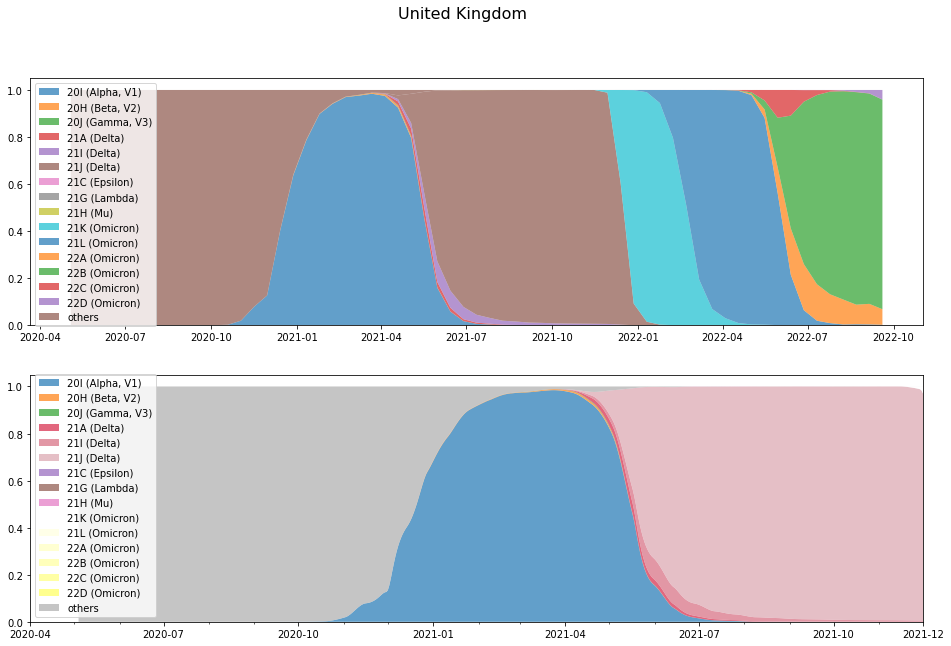

In [11]:
for i, country in enumerate(countries_focus):
    df = dfs_plot[i]
    if do_smooth:
        df_smooth = dfs_smooth_plot[i]
    x = df.index
    y = [df[variant] for variant in df.columns]


    fig, axs = plt.subplots(2, figsize=[16,10])
    fig.suptitle(country, fontsize = 16)

    axs[0].stackplot(x, y, labels=df.columns, alpha=0.7)
    axs[0].legend(loc='upper left')
    if do_smooth:
        df_smooth.plot.area(ax = axs[1], alpha=0.7, lw=0, color = mycolors)
        axs[1].set_xlim([datetime.date(2020, 4, 1), datetime.date(2021, 12, 1)])
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.show()
    break

# OWID_data

## Acquire data from "Our world in data"

In [12]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv
!mv owid-covid-data.csv ../Data/metadata/Owid_data/.

--2022-09-30 21:16:43--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.137, 104.21.233.138
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [              <=>   ]  59.49M  19.3MB/s    in 3.1s    

2022-09-30 21:16:47 (19.3 MB/s) - ‘owid-covid-data.csv’ saved [62377166]



## Read data

In [13]:
raw_owid_df = pd.read_csv('../Data/metadata/Owid_data/owid-covid-data.csv')

In [14]:
raw_owid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

## Data extracting (location, date, people_vaccinated_per_hundred, new_cases_smoothed)

In [15]:
owid_dfs = []
#location, date, people_vaccinated_per_hundred, new_cases_smoothed
columns_extract = ['location', 'date', 'people_vaccinated_per_hundred', 'new_cases_smoothed','new_cases_smoothed_per_million']
for country in countries_focus:
    owid_df = raw_owid_df[raw_owid_df['location'] == country]
    owid_df = owid_df[columns_extract]
    #owid_df = owid_df.dropna()
    owid_df.index = pd.DatetimeIndex(owid_df['date'])
    #print(owid_df)
    owid_dfs.append(owid_df)


# Merge data plots

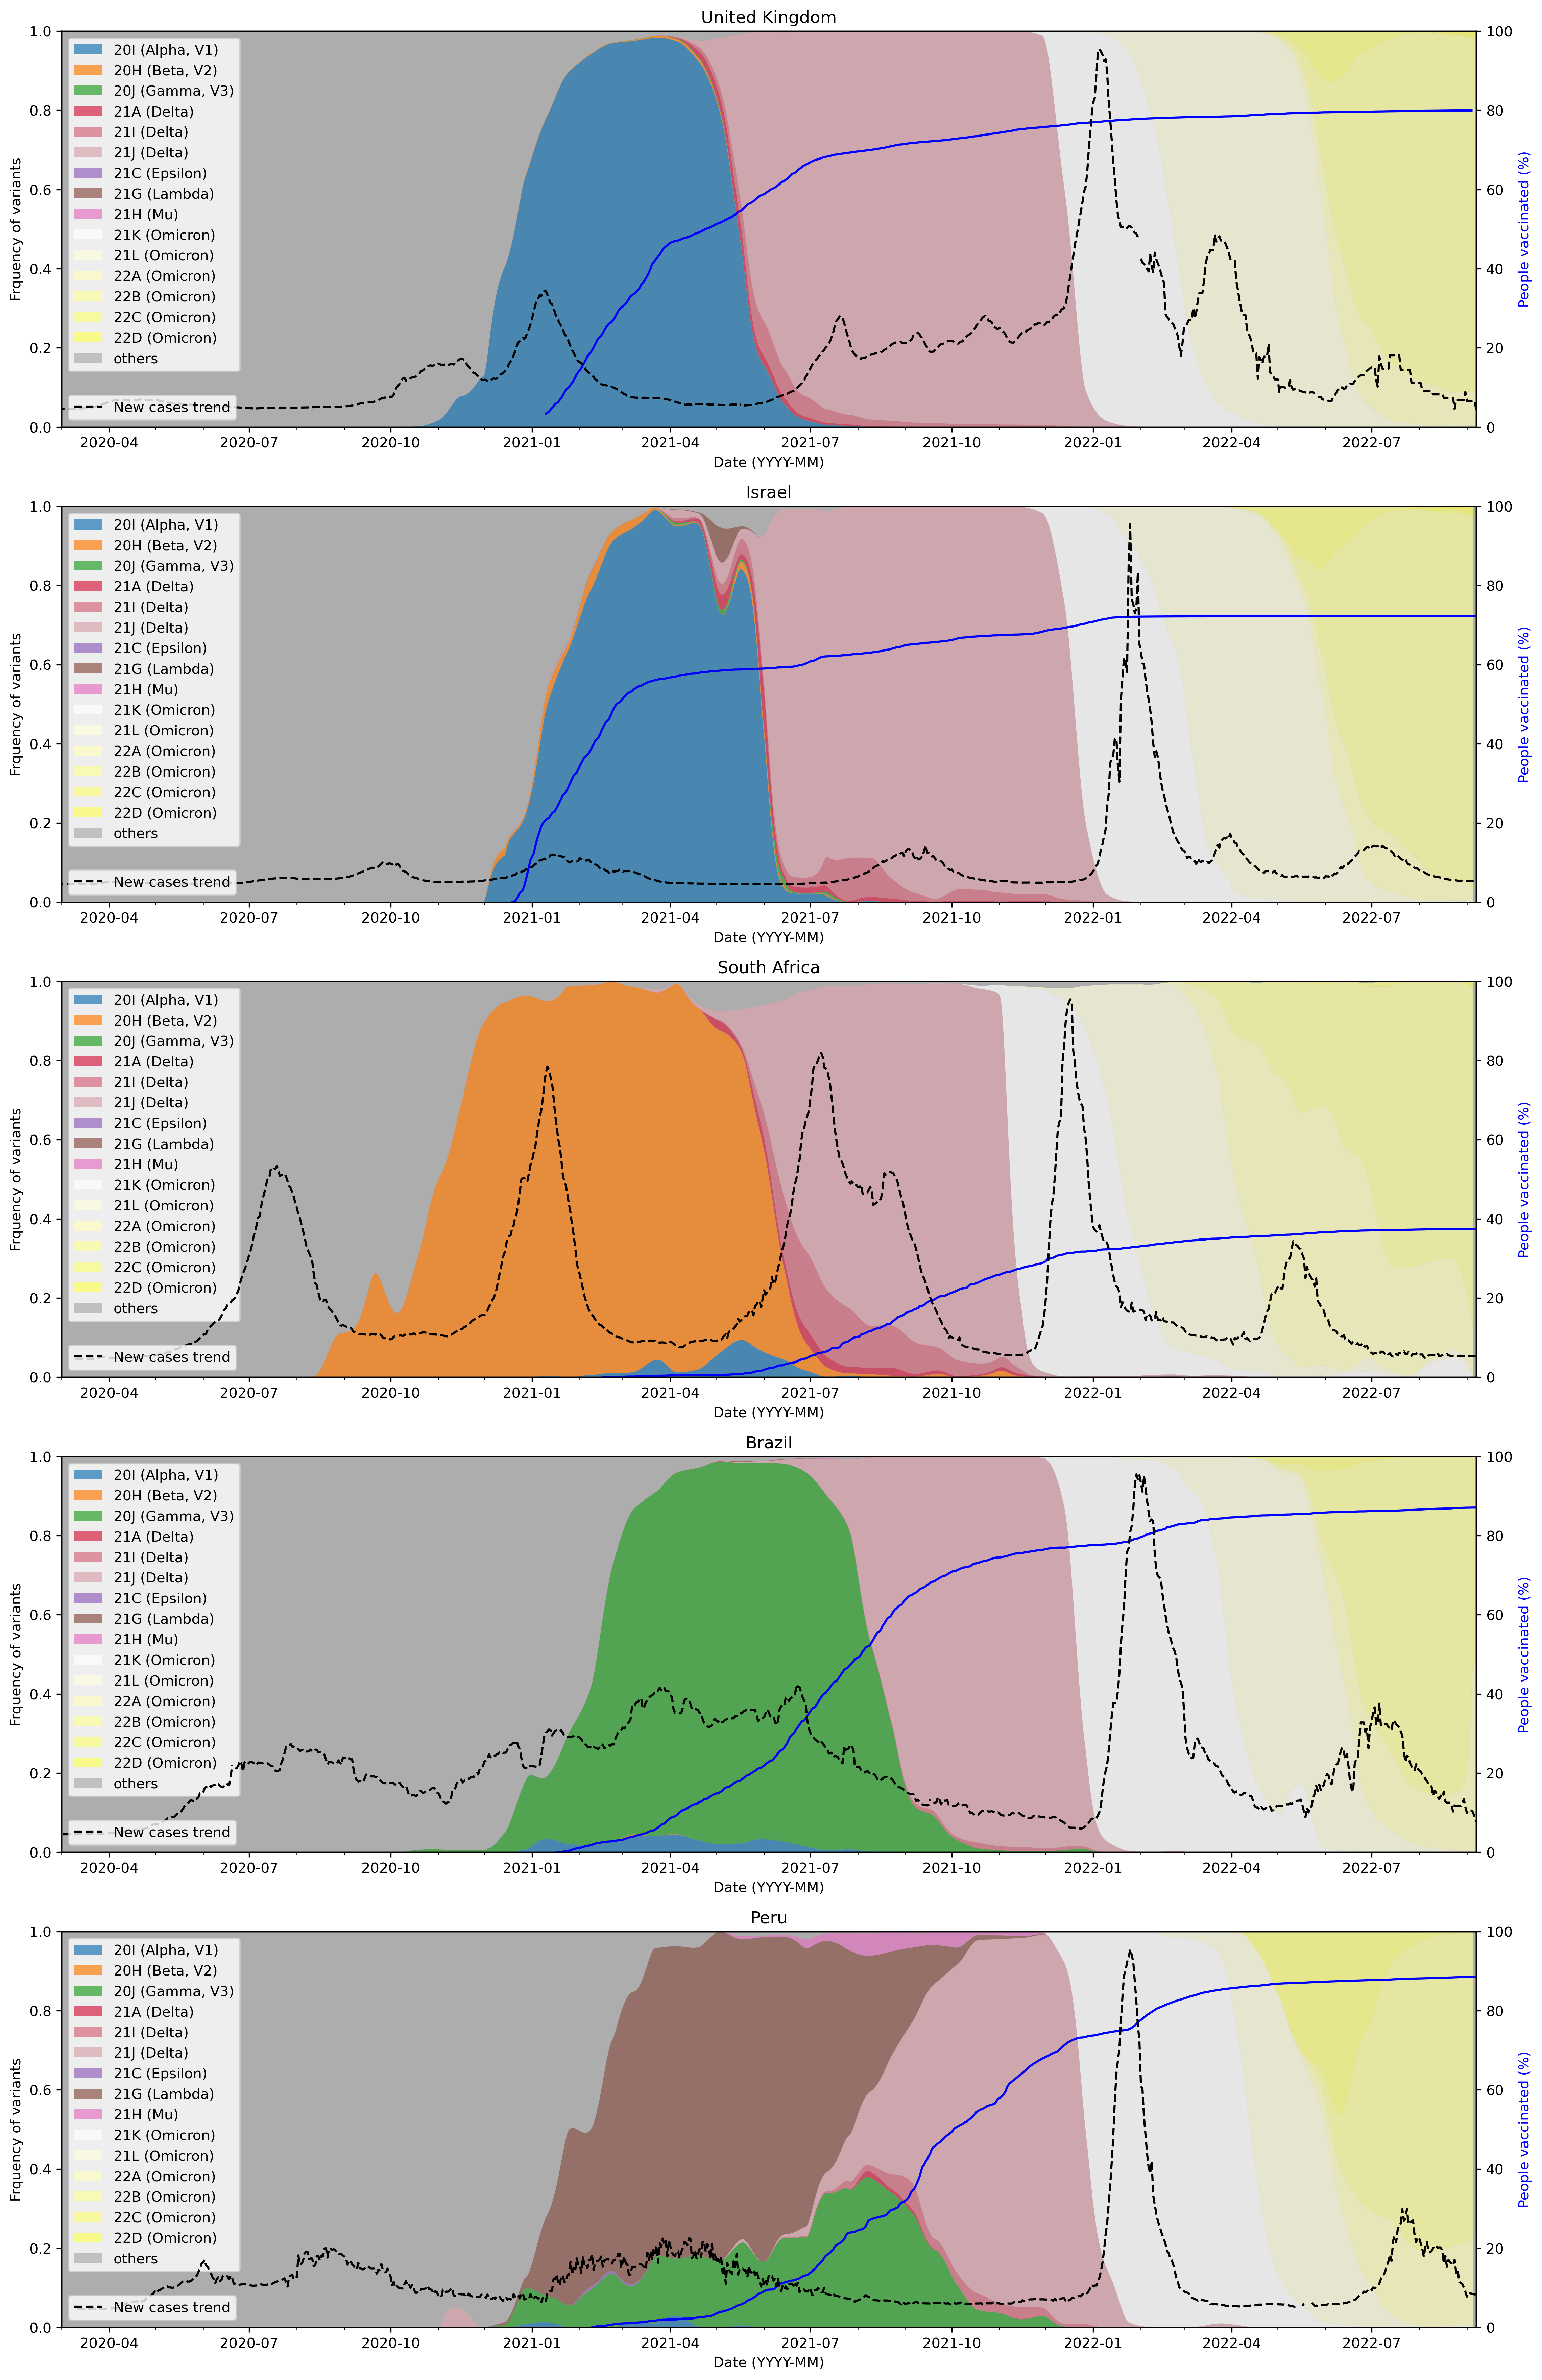

In [17]:
fig, axs = plt.subplots(len(countries_focus), figsize=[18,30],dpi=300)

for i, country in enumerate(countries_focus):
    df = dfs_plot[i]
    owid_df = owid_dfs[i]
    if do_smooth:
        df_smooth = dfs_smooth_plot[i]
    x = df.index
    y = [df[variant] for variant in df.columns]

    axs[i].title.set_text(country)
    
    if do_smooth:
        twin1 = axs[i].twinx()
        twin2 = axs[i].twinx()
        df_smooth.plot.area(ax = axs[i], alpha=0.7, lw=0, color=mycolors)
        axs[i].set_facecolor('#adadad')
        axs[i].set_xlim([datetime.date(2020, 3, 1), datetime.date(2022, 9, 7)]) # change end date here
        axs[i].set_xlabel('Date (YYYY-MM)')
        axs[i].set_ylabel('Frquency of variants')
        axs[i].legend(loc = 'upper left')
        if do_seq_freq:
            axs[i].set_ylim([0,1])
        
        
        owid_df_vac = owid_df['people_vaccinated_per_hundred'].dropna()
        twin1.plot_date(owid_df_vac.index, owid_df_vac, fmt = '-', color = 'blue')
        twin1.set_ylabel('People vaccinated (%)', color='blue')
        twin1.set_ylim([0,100])

        twin2.plot_date(owid_df.index,owid_df['new_cases_smoothed'], fmt = '--', color = 'black')
        twin2.tick_params(axis = 'y', which = 'both', right = False, top = False, labelright = False)
        twin2.legend(["New cases trend"], loc = 'lower left')
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.show()

    